In [1]:
using ComputationalHeatTransfer

┌ Info: Precompiling ComputationalHeatTransfer [5fc296c8-2eb5-40dc-a46d-98a68011a900]
└ @ Base loading.jl:1278


In [2]:
# using Plots
using LaTeXStrings
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
# using Revise
# using LinearAlgebra
# using DifferentialEquations
# using Interpolations
# using Plots
# pyplot()

In [4]:
# cd(dirname(pwd()))
# cd("src") 

# includet("OneDOHP.jl")
# using ..OneDOHP

### Physical parameters

In [283]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.002)

### Geometry parameters

In [284]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [285]:
xlim = (-Lx/2,Lx/2) .* 1.1
ylim = (-Ly/2,Ly/2) .* 1.1
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000.0)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

(0.00048567444811398473, 0.00023587966955082365)

### Set up the boundary of the domain

In [286]:
bdry = Rectangle(Lx/2,Ly/2,1.5Δx)

Rectangular body with 594 points and half-lengths (0.0762,0.0324)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [287]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((-2inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((2inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = -30.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

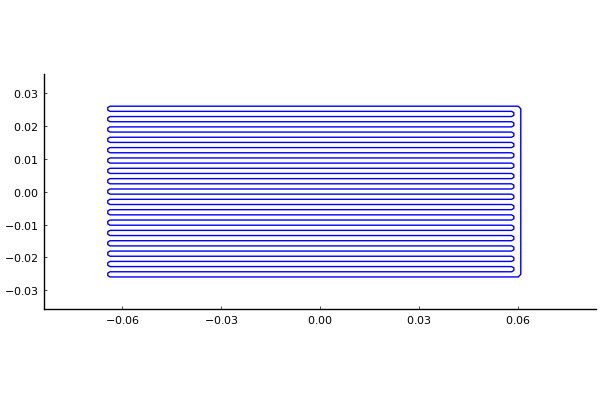

In [288]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = Ly*0.8
height = Lx*0.8
gap = 2*d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [289]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [306]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=eparams,bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 350 x 150 and 594 static immersed points
   1 body


#### Initialize state, and create the integrator

In [291]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 350, ny = 150) cell grid of type Float64 data
  Number of Primal nodes: (nx = 349, ny = 149), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [292]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 350 x 150 and 594 static immersed points
   1 body


In [298]:
@time step!(integrator,0.3)
maximum(integrator.u[:])

428.177600 seconds (12.82 M allocations: 49.681 GiB, 6.86% gc time)


1.2683220323584725

In [299]:
integrator.t

0.40002310388142837

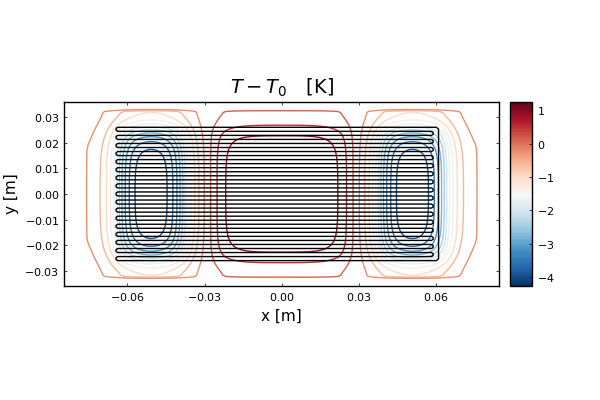

In [300]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T - T_0 \quad [\mathrm{K}]")
# plot!(ohp,fillalpha=0,line_z=qtmp)
plot!(ohp,fillalpha=0,linecolor=:black)

In [301]:
xc, yc = coordinates(temperature(integrator),sys.grid);

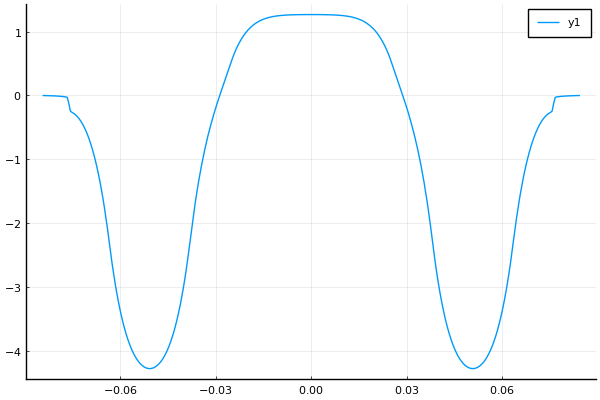

In [302]:
plot(xc,temperature(integrator)[:,floor(Int,size(sys.grid,2)/2)])

In [ ]:
maximum(integrator.u[:])

In [305]:
temperature_linesource(integrator)

LoadError: [91mMethodError: no method matching getindex(::Nothing, ::Int64)[39m

### Plot the temperature along the OHP channel

In [ ]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

In [303]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

LoadError: [91mMethodError: no method matching getindex(::Nothing, ::Int64)[39m